In [1]:
# ==========================================================
# IST 615 – Final Project Progressive Submission (Week 10)
# Author: Lokesh Sivaprakash
# Topic: Predicting Customer Subscription to Term Deposits
# ==========================================================

# 1️⃣  Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# 2️⃣  Load dataset
df = pd.read_csv("bank-full.csv", sep=';')
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [2]:
# ================================
# Data Cleaning and Preprocessing
# ================================

import numpy as np
import pandas as pd

# 1. Dataset size before cleaning
print("Dataset shape BEFORE cleaning:", df.shape)

# 2. "unknown" analysis BEFORE cleaning
unknown_summary = (df == "unknown").sum().to_frame("unknown_count")
unknown_summary["unknown_pct"] = (unknown_summary["unknown_count"] / len(df) * 100).round(2)
print("\nColumns with 'unknown' BEFORE cleaning:")
print(unknown_summary[unknown_summary["unknown_count"] > 0])

# 3. Replace 'unknown' with NaN
df.replace("unknown", np.nan, inplace=True)

# 4. Missing after conversion
missing_after = df.isna().sum().to_frame("missing_count")
missing_after["missing_pct"] = (missing_after["missing_count"] / len(df) * 100).round(2)
print("\nMissing values AFTER converting 'unknown' → NaN:")
print(missing_after[missing_after["missing_count"] > 0])

# 5. Fill missing categorical values with 'Other'
for col in df.select_dtypes('object').columns:
    df[col] = df[col].fillna('Other')

print("\nDataset shape AFTER cleaning:", df.shape)

# 6. Define numeric & categorical columns
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
cat_cols = [c for c in df.columns if c not in num_cols + ['y']]

# 7. BEFORE vs AFTER clipping summaries for numeric features
pre_clip = df[num_cols].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T
print("\n=== Numeric summary BEFORE clipping (min, 1%, 50%, 99%, max) ===")
print(pre_clip[['min', '1%', '50%', '99%', 'max']])

# Clip numeric outliers (1st–99th percentile)
for c in num_cols:
    low, high = df[c].quantile([0.01, 0.99])
    df[c] = df[c].clip(low, high)

post_clip = df[num_cols].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99]).T
print("\n=== Numeric summary AFTER clipping (min, 1%, 50%, 99%, max) ===")
print(post_clip[['min', '1%', '50%', '99%', 'max']])


Dataset shape BEFORE cleaning: (45211, 17)

Columns with 'unknown' BEFORE cleaning:
           unknown_count  unknown_pct
job                  288         0.64
education           1857         4.11
contact            13020        28.80
poutcome           36959        81.75

Missing values AFTER converting 'unknown' → NaN:
           missing_count  missing_pct
job                  288         0.64
education           1857         4.11
contact            13020        28.80
poutcome           36959        81.75

Dataset shape AFTER cleaning: (45211, 17)

=== Numeric summary BEFORE clipping (min, 1%, 50%, 99%, max) ===
             min     1%    50%      99%       max
age         18.0   23.0   39.0     71.0      95.0
balance  -8019.0 -627.0  448.0  13164.9  102127.0
day          1.0    2.0   16.0     31.0      31.0
duration     0.0   11.0  180.0   1269.0    4918.0
campaign     1.0    1.0    2.0     16.0      63.0
pdays       -1.0   -1.0   -1.0    370.0     871.0
previous     0.0    0.0    

Overall subscription rate: 11.70%


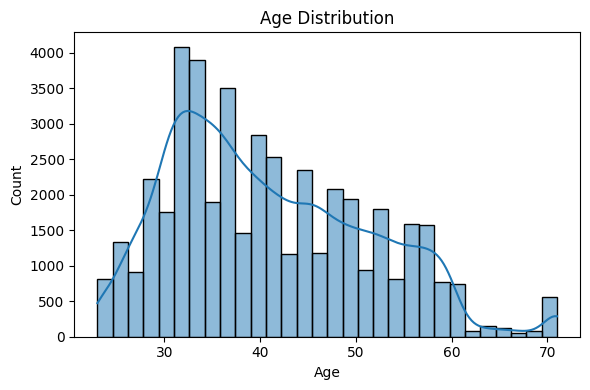


Age summary (min, 25%, 50%, 75%, max):
min    23.0
25%    33.0
50%    39.0
75%    48.0
max    71.0
Name: age, dtype: float64

Subscription rate by job:
               subscription_rate     n  subscription_rate_pct
job                                                          
student                 0.286780   938                   28.7
retired                 0.227915  2264                   22.8
unemployed              0.155027  1303                   15.5
management              0.137556  9458                   13.8
admin.                  0.122027  5171                   12.2
self-employed           0.118429  1579                   11.8
Other                   0.118056   288                   11.8
technician              0.110570  7597                   11.1
services                0.088830  4154                    8.9
housemaid               0.087903  1240                    8.8
entrepreneur            0.082717  1487                    8.3
blue-collar             0.072750  9732   

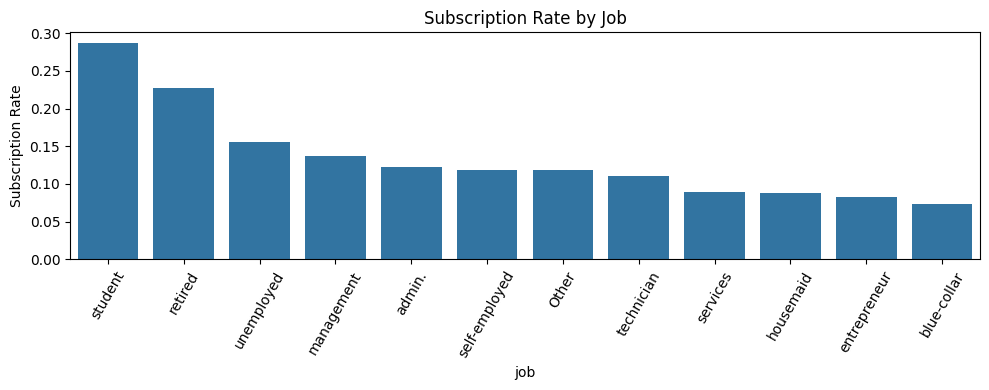


marital distribution (count):
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

marital distribution (%):
marital
married     60.2
single      28.3
divorced    11.5
Name: proportion, dtype: float64

education distribution (count):
education
secondary    23202
tertiary     13301
primary       6851
Other         1857
Name: count, dtype: int64

education distribution (%):
education
secondary    51.3
tertiary     29.4
primary      15.2
Other         4.1
Name: proportion, dtype: float64

contact distribution (count):
contact
cellular     29285
Other        13020
telephone     2906
Name: count, dtype: int64

contact distribution (%):
contact
cellular     64.8
Other        28.8
telephone     6.4
Name: proportion, dtype: float64

month distribution (count):
month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64

month distr

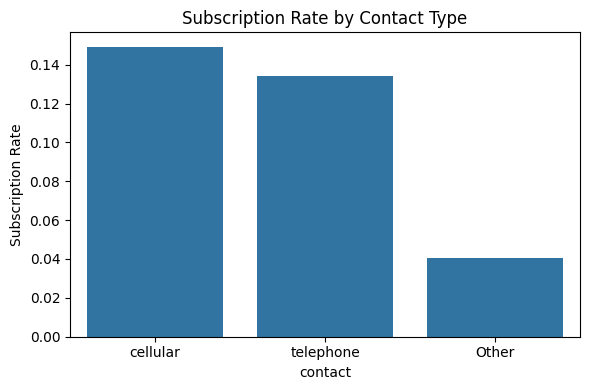


Subscription rate by month:
       subscription_rate      n  subscription_rate_pct
month                                                 
mar             0.519916    477                   52.0
dec             0.467290    214                   46.7
sep             0.464594    579                   46.5
oct             0.437669    738                   43.8
apr             0.196794   2932                   19.7
feb             0.166478   2649                   16.6
aug             0.110133   6247                   11.0
jun             0.102228   5341                   10.2
nov             0.101511   3970                   10.2
jan             0.101212   1403                   10.1
jul             0.090935   6895                    9.1
may             0.067195  13766                    6.7


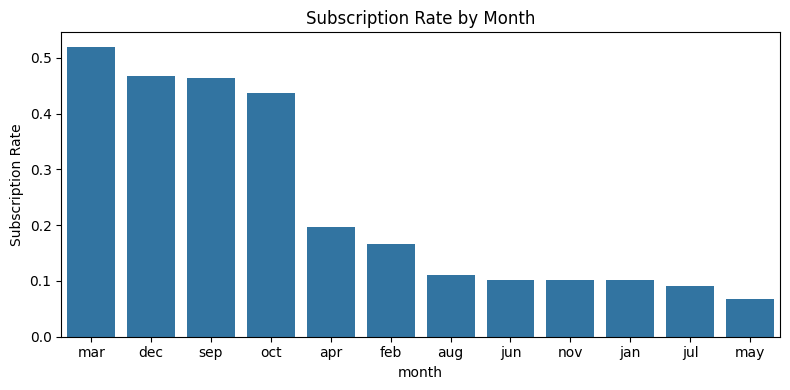

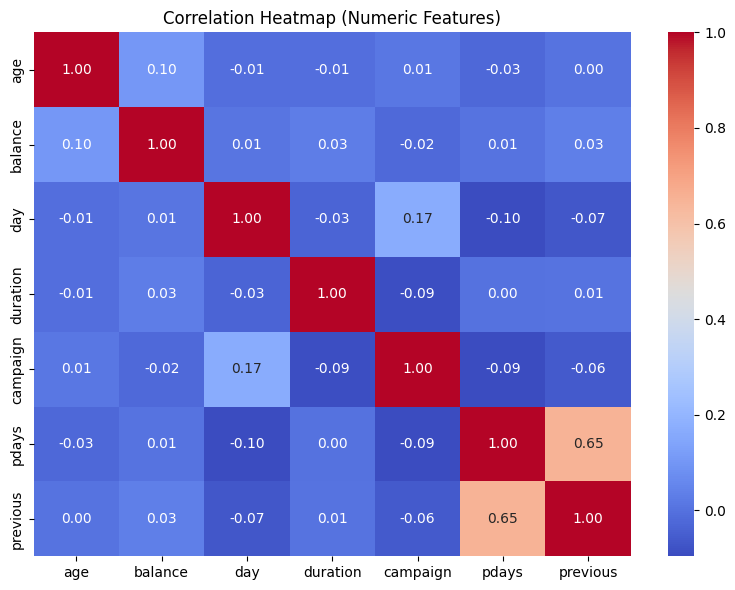


Correlation between duration and y_binary:
0.410046282991839

Subscription rate by duration bin:
duration_bin
(10.999, 89.0]     0.007
(89.0, 147.0]      0.037
(147.0, 223.0]     0.079
(223.0, 368.0]     0.131
(368.0, 1269.0]    0.332
Name: y_binary, dtype: float64

Correlation between pdays and previous:
0.6511858893814896


C:\Users\lokes\AppData\Local\Temp\ipykernel_9156\2458233389.py:140: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  duration_rates = df.groupby('duration_bin')['y_binary'].mean().round(3)


In [3]:
# ---- Descriptive Analytics  ----

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------------------------------------------
# 1. Target as numeric + overall subscription rate
# -------------------------------------------------------------------
df['y_binary'] = df['y'].map({'yes': 1, 'no': 0})

overall_rate = df['y_binary'].mean()
print(f"Overall subscription rate: {overall_rate:.2%}")  # e.g. 11.27%


# -------------------------------------------------------------------
# 2. Age distribution (same plot, but now tied to numbers)
# -------------------------------------------------------------------
plt.figure(figsize=(6,4))
sns.histplot(df['age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("\nAge summary (min, 25%, 50%, 75%, max):")
print(df['age'].describe()[['min', '25%', '50%', '75%', 'max']])
# You can use these numbers in the report (e.g., "most clients are between 30–50")


# -------------------------------------------------------------------
# 3. Subscription rate by job (with numbers + plot)
# -------------------------------------------------------------------
job_rates = (
    df.groupby('job')['y_binary']
      .agg(subscription_rate='mean', n='size')
      .sort_values('subscription_rate', ascending=False)
)
job_rates['subscription_rate_pct'] = (job_rates['subscription_rate'] * 100).round(1)

print("\nSubscription rate by job:")
print(job_rates)

plt.figure(figsize=(10,4))
sns.barplot(
    x=job_rates.index,
    y=job_rates['subscription_rate'],
    order=job_rates.index
)
plt.xticks(rotation=60)
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Job")
plt.tight_layout()
plt.show()

# Use job_rates in the report, e.g.:
# retirees: job_rates.loc['retired', 'subscription_rate_pct']


# -------------------------------------------------------------------
# 4. Categorical distributions (marital, education, contact, month)
# -------------------------------------------------------------------
for col in ['marital', 'education', 'contact', 'month']:
    print(f"\n{col} distribution (count):")
    print(df[col].value_counts())
    print(f"\n{col} distribution (%):")
    print((df[col].value_counts(normalize=True) * 100).round(1))


# -------------------------------------------------------------------
# 5. Subscription rate by contact type (extra cross-tab + visual)
# -------------------------------------------------------------------
contact_rates = (
    df.groupby('contact')['y_binary']
      .agg(subscription_rate='mean', n='size')
      .sort_values('subscription_rate', ascending=False)
)
contact_rates['subscription_rate_pct'] = (contact_rates['subscription_rate'] * 100).round(1)

print("\nSubscription rate by contact type:")
print(contact_rates)

plt.figure(figsize=(6,4))
sns.barplot(
    x=contact_rates.index,
    y=contact_rates['subscription_rate'],
    order=contact_rates.index
)
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Contact Type")
plt.tight_layout()
plt.show()


# -------------------------------------------------------------------
# 6. Subscription rate by month (extra cross-tab + visual)
# -------------------------------------------------------------------
month_rates = (
    df.groupby('month')['y_binary']
      .agg(subscription_rate='mean', n='size')
      .sort_values('subscription_rate', ascending=False)
)
month_rates['subscription_rate_pct'] = (month_rates['subscription_rate'] * 100).round(1)

print("\nSubscription rate by month:")
print(month_rates)

plt.figure(figsize=(8,4))
sns.barplot(
    x=month_rates.index,
    y=month_rates['subscription_rate'],
    order=month_rates.index
)
plt.ylabel("Subscription Rate")
plt.title("Subscription Rate by Month")
plt.tight_layout()
plt.show()


# -------------------------------------------------------------------
# 7. Correlation heatmap for numeric columns
#    (make sure num_cols does NOT include 'duration' later on)
# -------------------------------------------------------------------
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.show()

# -----------------------------------
# Duration leakage check (for report)
# -----------------------------------

print("\nCorrelation between duration and y_binary:")
print(df[['duration', 'y_binary']].corr().iloc[0, 1])

# Bin duration into 5 groups and check subscription rate
df['duration_bin'] = pd.qcut(df['duration'], q=5, duplicates='drop')
duration_rates = df.groupby('duration_bin')['y_binary'].mean().round(3)

print("\nSubscription rate by duration bin:")
print(duration_rates)

# Clean up temp column
df.drop(columns=['duration_bin'], inplace=True)

# -----------------------------------
# Correlation between pdays and previous
# -----------------------------------

print("\nCorrelation between pdays and previous:")
print(df[['pdays', 'previous']].corr().iloc[0, 1])



Numeric columns used (duration removed): ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
Stratified 5-Fold CV ROC-AUC Mean: 0.7675295617609201
Stratified 5-Fold CV ROC-AUC Std: 0.008213102835739136

Classification Report (Calibrated, Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     11977
           1       0.67      0.19      0.29      1587

    accuracy                           0.89     13564
   macro avg       0.79      0.59      0.62     13564
weighted avg       0.87      0.89      0.87     13564


Classification Report (Calibrated, Threshold = 0.3):
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     11977
           1       0.49      0.39      0.44      1587

    accuracy                           0.88     13564
   macro avg       0.71      0.67      0.69     13564
weighted avg       0.87      0.88      0.88     13564


Calibrated ROC-AUC (test): 0

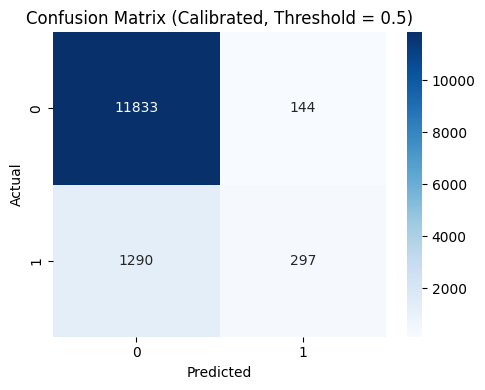

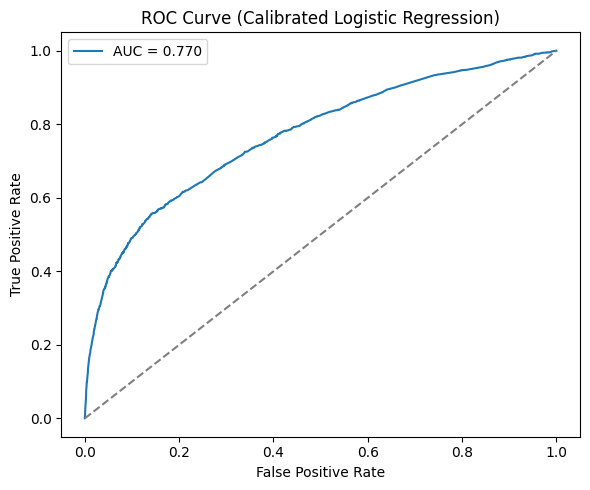

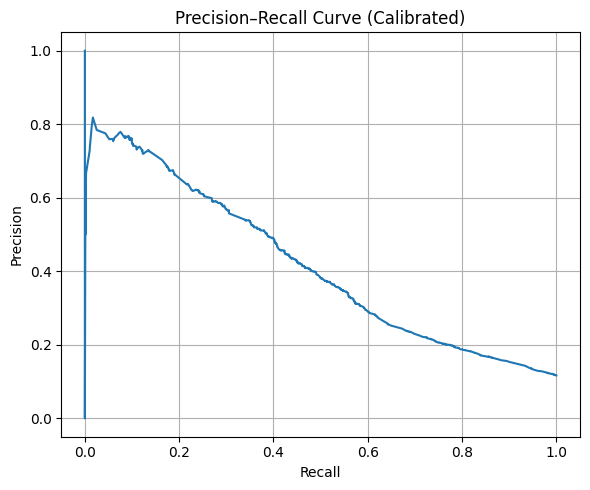


Top Positive Predictors (base LR):
              feature      coef
49   poutcome_success  1.662531
41          month_mar  1.246019
44          month_oct  0.944264
36          month_dec  0.849802
45          month_sep  0.804844
32   contact_cellular  0.511174
12        job_retired  0.498998
15        job_student  0.387853
33  contact_telephone  0.310915
27         housing_no  0.261533

Top Negative Predictors (base LR):
             feature      coef
10     job_housemaid -0.336076
48    poutcome_other -0.394138
42         month_may -0.430135
47  poutcome_failure -0.583889
46    poutcome_Other -0.586615
39         month_jul -0.588530
31     contact_Other -0.724200
35         month_aug -0.739796
43         month_nov -0.849318
38         month_jan -1.027132


In [4]:
# ---- Predictive Modeling (with Stratified CV + Calibration) ----
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
from sklearn.calibration import CalibratedClassifierCV

# ---------------------------------------------
# 1. Define features (duration removed) & split
# ---------------------------------------------
num_cols_fixed = [c for c in num_cols if c != "duration"]
print("Numeric columns used (duration removed):", num_cols_fixed)

X = df[num_cols_fixed + cat_cols]
y = df["y_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ---------------------------------------------
# 2. Preprocessing + base Logistic Regression
# ---------------------------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_fixed),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

# Base pipeline (used for CV + coefficients)
model_lr = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", log_reg)
])

# Fit base LR model
model_lr.fit(X_train, y_train)

# ---------------------------------------------
# 3. Stratified 5-fold Cross-Validation (ROC-AUC)
# ---------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    model_lr, X, y,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

print("Stratified 5-Fold CV ROC-AUC Mean:", cv_scores.mean())
print("Stratified 5-Fold CV ROC-AUC Std:", cv_scores.std())

# ---------------------------------------------
# 4. Probability Calibration (Isotonic)
# ---------------------------------------------
from sklearn.calibration import CalibratedClassifierCV

cal_model = CalibratedClassifierCV(
    estimator=model_lr,   # or just CalibratedClassifierCV(model_lr, ...)
    method="isotonic",
    cv=5
)


cal_model.fit(X_train, y_train)

# Use calibrated probabilities on test set
y_prob_cal = cal_model.predict_proba(X_test)[:, 1]

# Threshold-based predictions (0.5 & 0.3)
y_pred_05 = (y_prob_cal >= 0.5).astype(int)
y_pred_03 = (y_prob_cal >= 0.3).astype(int)

print("\nClassification Report (Calibrated, Threshold = 0.5):")
print(classification_report(y_test, y_pred_05))

print("\nClassification Report (Calibrated, Threshold = 0.3):")
print(classification_report(y_test, y_pred_03))

roc_auc_cal = roc_auc_score(y_test, y_prob_cal)
print(f"\nCalibrated ROC-AUC (test): {roc_auc_cal:.4f}")

# ---------------------------------------------
# 5. Confusion Matrix at 0.5 (Calibrated)
# ---------------------------------------------
plt.figure(figsize=(5, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred_05),
    annot=True, fmt="d", cmap="Blues"
)
plt.title("Confusion Matrix (Calibrated, Threshold = 0.5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 6. ROC Curve (Calibrated)
# ---------------------------------------------
fpr, tpr, _ = roc_curve(y_test, y_prob_cal)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_cal:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Calibrated Logistic Regression)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 7. Precision–Recall Curve (Calibrated)
# ---------------------------------------------
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob_cal)
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions)
plt.title("Precision–Recall Curve (Calibrated)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 8. Coefficients from *base* LR (for interpretability)
#    (use model_lr, not cal_model)
# ---------------------------------------------
# Refit base LR on full training set just to be safe
model_lr.fit(X_train, y_train)

# Get encoded feature names
ohe = model_lr.named_steps["preprocess"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([num_cols_fixed, cat_features])

coefs = model_lr.named_steps["classifier"].coef_[0]
coef_df = pd.DataFrame({"feature": all_feature_names, "coef": coefs})
coef_df = coef_df.sort_values("coef", ascending=False)

print("\nTop Positive Predictors (base LR):")
print(coef_df.head(10))

print("\nTop Negative Predictors (base LR):")
print(coef_df.tail(10))


Segment Summary (Low / Medium / High):
         count  mean_prob  sub_rate  count_pct  mean_prob_pct  sub_rate_pct  \
segment                                                                       
Low      15217   0.039209  0.038970       33.7           3.92          3.90   
Medium   14996   0.072501  0.072686       33.2           7.25          7.27   
High     14998   0.240085  0.240432       33.2          24.01         24.04   

         expected_subscribers  
segment                        
Low                     593.0  
Medium                 1090.0  
High                   3606.0  

If we only call Medium + High segments, call volume reduces by: 33.7%
Expected subscribers covered when calling Medium + High: 88.8%

Segment Actions:

High Segment:
 - Prioritize immediate follow-up via cellular contact
 - Offer personalized deposit rates or incentives

Medium Segment:
 - Use 1–2 touch nurturing via email + call

Low Segment:
 - Reduce repeated calls; move to low-cost email drip

Ave

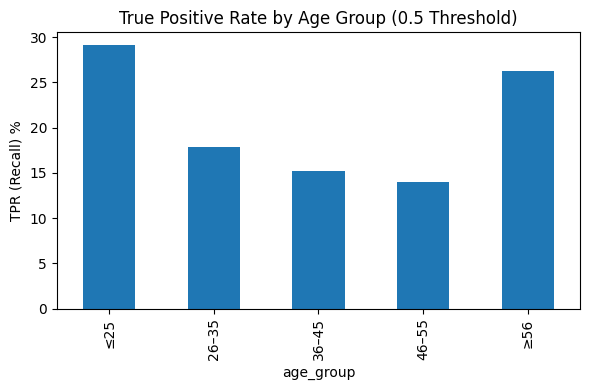

In [5]:
# --- Prescriptive Analytics and Ethical Checks ---

from sklearn.metrics import classification_report

# 1. Prescriptive segmentation on FULL DATA (calibrated probabilities)
df["prob"] = cal_model.predict_proba(X)[:, 1]
df["segment"] = pd.qcut(df["prob"], q=3, labels=["Low", "Medium", "High"])

seg_summary = (
    df.groupby("segment", observed=True)
      .agg(
          count=("y_binary", "size"),
          mean_prob=("prob", "mean"),
          sub_rate=("y_binary", "mean")
      )
)

seg_summary["count_pct"] = (seg_summary["count"] / len(df) * 100).round(1)
seg_summary["mean_prob_pct"] = (seg_summary["mean_prob"] * 100).round(2)
seg_summary["sub_rate_pct"] = (seg_summary["sub_rate"] * 100).round(2)
seg_summary["expected_subscribers"] = (seg_summary["sub_rate"] * seg_summary["count"]).round(0)

print("Segment Summary (Low / Medium / High):")
print(seg_summary)

# Simple call-volume saving
calls_all = len(df)
calls_med_high = seg_summary.loc["Medium", "count"] + seg_summary.loc["High", "count"]
call_savings_pct = 1 - (calls_med_high / calls_all)

print(f"\nIf we only call Medium + High segments, call volume reduces by: {call_savings_pct:.1%}")
total_expected_subs = seg_summary["expected_subscribers"].sum()
coverage_pct = seg_summary.loc[["Medium", "High"], "expected_subscribers"].sum() / total_expected_subs
print(f"Expected subscribers covered when calling Medium + High: {coverage_pct:.1%}")

print("\nSegment Actions:")
actions = {
    "High": [
        "Prioritize immediate follow-up via cellular contact",
        "Offer personalized deposit rates or incentives",
    ],
    "Medium": [
        "Use 1–2 touch nurturing via email + call",
    ],
    "Low": [
        "Reduce repeated calls; move to low-cost email drip",
    ],
}
for seg_label, rules in actions.items():
    print(f"\n{seg_label} Segment:")
    for r in rules:
        print(" -", r)

# --- 2. Ethical checks: Age fairness (prob + TPR + support) ---

# If you are using calibrated probabilities, replace y_prob_test with your calibrated array
y_prob_test = y_prob_cal  # if you named it differently, adjust here
y_pred_test_05 = (y_prob_test >= 0.5).astype(int)

fair_df = pd.DataFrame({
    'y_true': y_test.values,
    'y_pred': y_pred_test_05,
    'prob': y_prob_test,
    'age': X_test['age'].values
})

age_bins = pd.cut(
    fair_df['age'],
    bins=[-1, 25, 35, 45, 55, 200],
    labels=['≤25', '26–35', '36–45', '46–55', '≥56']
)
fair_df['age_group'] = age_bins

# Average predicted probability by age group
avg_prob_by_age = fair_df.groupby('age_group', observed=True)['prob'].mean() * 100
print("\nAverage Predicted Probability by Age Group (%):")
print(avg_prob_by_age.round(2))

# True Positive Rate (only among actual subscribers) + support
fair_subs = fair_df[fair_df['y_true'] == 1]
fair_table = fair_subs.groupby('age_group', observed=True).agg(
    support=('y_true', 'count'),
    tpr=('y_pred', 'mean')
)
fair_table['tpr_pct'] = (fair_table['tpr'] * 100).round(2)

print("\nTrue Positive Rate (Recall) by Age Group at Threshold 0.5 (%), with support:")
print(fair_table[['support', 'tpr_pct']])

# (Optional) bar chart for TPR
plt.figure(figsize=(6,4))
fair_table['tpr_pct'].plot(kind='bar')
plt.ylabel("TPR (Recall) %")
plt.title("True Positive Rate by Age Group (0.5 Threshold)")
plt.tight_layout()
plt.show()



#Markdown

**Challenges Encountered:**
- The dataset contained many "unknown" categorical values, which required conversion to missing values and careful imputation using an “Other” category.
- Several numerical variables contained extreme outliers. These were handled by clipping at the 1st and 99th percentiles to preserve distributional shape without removing rows.
- The target variable was highly imbalanced, making threshold selection and evaluation more difficult.
- Probability calibration was necessary because the raw Logistic Regression model produced overconfident probability estimates.
- Strong correlation between certain features (e.g., pdays and previous) required explicit modeling justification.
- Duration was found to be highly predictive but represented post-contact information, so it was excluded from modeling to prevent data leakage.

**Next Steps:**
- Compare Logistic Regression with Random Forest and Decision Tree.
- Address imbalance using class weights or SMOTE.
- Expand feature importance analysis.



Model Comparison (ROC-AUC):
                            Model   ROC-AUC
2        Random Forest (Balanced)  0.787556
0  Logistic Regression (Balanced)  0.770091
1        Decision Tree (Balanced)  0.605964

Top Random Forest Predictors:
             feature  importance
1            balance    0.158341
0                age    0.134156
2                day    0.119529
3           campaign    0.067452
4              pdays    0.037131
49  poutcome_success    0.035855
31     contact_Other    0.026144
5           previous    0.023498
32  contact_cellular    0.020569
28       housing_yes    0.017956


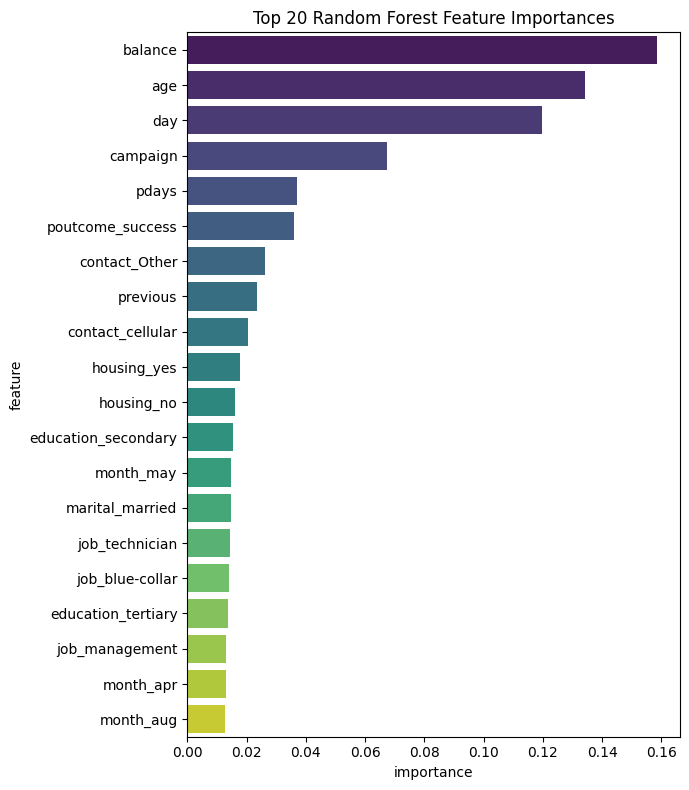


Top Decision Tree Predictors:
             feature  importance
1            balance    0.204917
2                day    0.126416
0                age    0.118634
49  poutcome_success    0.079707
3           campaign    0.057842
31     contact_Other    0.048305
4              pdays    0.035827
28       housing_yes    0.022195
35         month_aug    0.017004
39         month_jul    0.016820


In [23]:
# ============================
#  Model Comparison & Expanded Feature Importance
# ============================

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 1. Compare ROC-AUC across models
models = {
    "Logistic Regression (Balanced)": LogisticRegression(
        max_iter=1000, class_weight='balanced', n_jobs=-1
    ),
    "Decision Tree (Balanced)": DecisionTreeClassifier(
        class_weight='balanced', random_state=42
    ),
    "Random Forest (Balanced)": RandomForestClassifier(
        n_estimators=300,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
}

results = []

for name, clf in models.items():
    pipe = Pipeline(steps=[
        ('preprocess', preprocess),
        ('classifier', clf)
    ])
    pipe.fit(X_train, y_train)
    y_prob_model = pipe.predict_proba(X_test)[:, 1]
    auc_model = roc_auc_score(y_test, y_prob_model)
    results.append([name, auc_model])

results_df = pd.DataFrame(results, columns=['Model', 'ROC-AUC'])
print("\nModel Comparison (ROC-AUC):")
print(results_df.sort_values('ROC-AUC', ascending=False))

# 2. Expanded Feature Importance – Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', rf)
])
rf_pipe.fit(X_train, y_train)

rf_importances = rf_pipe.named_steps['classifier'].feature_importances_

rf_imp_df = pd.DataFrame({
    'feature': all_feature_names,   # defined in Cell 3
    'importance': rf_importances
}).sort_values("importance", ascending=False)

print("\nTop Random Forest Predictors:")
print(rf_imp_df.head(10))

plt.figure(figsize=(7,8))
sns.barplot(
    data=rf_imp_df.head(20),
    x='importance',
    y='feature',
    hue='feature',
    palette='viridis',
legend=False
)
plt.title("Top 20 Random Forest Feature Importances")
plt.tight_layout()
plt.show()

# 3. Expanded Feature Importance – Decision Tree
dt = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
)

dt_pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', dt)
])
dt_pipe.fit(X_train, y_train)

dt_importances = dt_pipe.named_steps['classifier'].feature_importances_

dt_imp_df = pd.DataFrame({
    'feature': all_feature_names,   # same feature space
    'importance': dt_importances
}).sort_values("importance", ascending=False)

print("\nTop Decision Tree Predictors:")
print(dt_imp_df.head(10))
